# Table of Contents
 <p>

# Introduction to False Hit Analysis


In the main paper, we introduce the notion of a false hit analysis. The purpose of this supplementary is to further expand upon this notion in a rigorous fashion.

Intuitively, the point of a false hit analysis is to verify whether or not a given intersection in a Venn diagram is the result of statistical errors. In general, we should be wary of intersections where: the size of the intersection is small relative to the other intersections (low detection power), the intersection has an unbelievable biological explanation (Occam's razor) and when our assay has significant false positive or false negative rates (high error flux). It may be possible to build an algorithm that tests two of the three conditions we enumerated, and gives us a *rough* estimate for the proportion of noise and signal in any given intersection.

**Note**: This Notebook is quite long. The $\chi^2$ calculations for the reduced and reclassified reduced models are at the bottom.


## Intuition
To gain for intuition of the algorithm, let's first consider how false negative and false positive rates work in a Venn diagram. Suppose that we have a Venn diagram of three different genotypes (like in the main paper). Then, there are 7 distinct intersections. We can think of these intersections as layered: The outermost intersections contain genes that are differentially expressed (DE) in only a single genotype (I call these intersections **genotype-specific**; the middle intersections contain genes that are DE in 2/3 genotypes (**genotype-associated**); and the inner intersection contains genes that are DE in all genotypes (let's call this one the **minimal model**, for reasons that will become clear later). This layering suggests to us that each intersection will have different vulnerabilities to different kinds of noise.

Let us consider the case where our three genotypes have affected 1/4 of the total genes in the *C. elegans* genome. Because most of the space is empty, the probability that we pick a false positive hit from the non-DE space if we pick genes at random from the genome is 3/4. This means that 3/4 of the false positive hits for any one genotype will fall into the **genotype-specific** classes. Thus, the **genotype-specific** classes will be most inflated by false positive hits. 

On the other hand, the only way for genes to enter into the **minimal model** is if they are DE in all three genotypes. This is a stringent requirement, and its stringency means this class is not as vulnerable to false positive hits. However, this class could easily lose genes to **genotype-associated** classes if a gene that is DE in all three genotypes was mistakenly said to be DE in only 2/3 genotypes. Moreover, notice that there are three ways for each gene to be misclassified as a result of a single false negative event (110, 101, 011). This simple argument suggests that the **minimal model** is most vulnerable to false negative events. Increasing the false negative rate will disproportionately affect the **minimal model**. 

This thought experiment has led us to the following propositions: False positive effects are *centripetal* (inward moving) because they will push genes from outer classes into inner classes, and false negative effects are centrifugal (outward moving), because they push genes from inner classes to outer classes. 

I.e:
False positives: **genotype-specific > genotype-associated > minimal model**
False negatives: **minimal model > genotype-associated > genotype-specific**

# Caveats

A major issue throughout this analysis will be that the false negative rate is notoriously difficult, if not impossible to establish. I am guessing here that my false negative rate is somewhere between 10-20%, but mammalian transcriptomes (which are much, much more complex than *C. elegans* transcriptomes, due to the increased sequence lengths and isoform complexities) have been estimated to have false negative rates of up to 90%. 

Another major issue with the algorithm I use below is that it generates matrices to estimate false positive and false negative flows, but it only consideres first order effects. Thus, if the false rates are much higher than 30%, the conclusions from the algorithm may be unstable.

# The method

The method relies on the construction of two distinct matrices: the False Positive and False Negative flow matrices.

To calculate the entries in the False Positive matrix, I:
 * Estimate the number of false positive hits in a given genotype. This is given by the product of the q-value significance threshold (0.1 for this study) and the number of differentially expressed genes that were found in a given genotype.
 * Calculate the probability that a gene is drawn from another intersection. By analogy above, the probability of picking a gene from the non-DE pool if we are picking uniformly is non-DE/# genes in the genome. 
 * Multiply the products.
 * Repeat for every possible first-order flow. I.e., the flows that happen if there is a single false positive event moving a gene *x* from intersection *A* to intersection *AB*. 
 
To calculate the entries in the False Negative matrix, I:
 * Estimate the number of genes removed from an intersection due to false-negative calls as the product of the *estimated* false negative rate (which is assumed to be the same for all the classes and genotypes) and the number of genes within each intersection, accounting for multiplicity (a gene *x* can be moved from *AB* to *A*, by a false negative in *B*, or from *AB* to *B* by a false negative in *A*).
 * Add the incoming genes from the inner classes to get the net flux.
 
 
The main idea behind the algorithm is the following.

Let $M$ be an object containing the **real** sizes of each intersection. Using the false negative and false positive fluxes above, we could add them to $M$ to estimate the sizes of $M_{obs}$, the observed classes.

Since $M$ is not known, we have to construct an algorithm to perform inference using $M_{obs}$ about the true shape of $M$. In general, since $M_{obs}$ is susceptible to statistical effects, $M_{obs}$ will tend to have more non-zero intersections than $M$.

As a first step, we should pick a subset of $M_{obs}$ that we can absolutely trust to exist. This means, we should pick the subset that is least likely to be the result of false positive rates. From our logic above, it stands to reason that the intersection that satisfies this condition is the **minimal model** (if it is non-zero in our data). Then, we initialize our algorithm by assuming the **minimal model** is the only real class. All the other genes are then added back to the non-DE category.

Now, we should estimate the false positive and false negative flows using only the **minimal model**. Using these flows, we can calculate a signal to noise ratio between the observation, $M_obs$ and the **minimal model**. If the signal/noise is close to 0, noise dominates. If the signal/noise is much greater than 1, we see many more genes than expected by chance alone.

We can refine the model by selecting those intersections that have a signal/noise ratio (SNR) greater than a value $\alpha$. Having accepted those intersections, we can refine our model for $M$ to a model $M_{ref}$, and perform the noise analysis one more time. In fact, we can do this until $M_{ref}$ converges. I call this final result, $M_{final}$, the **reduced model**.

In the model I implemented using the scripts below, I only account for first order events. A consequence of this is that sometimes the size of the intersections can become negative, since I over-estimate the effects of the false negative rate. When this happens, the SNR is treated as if it were infinite, and the observed class is accepted. 

In [1]:
import pandas as pd
import numpy as np
import scipy as scipy

import matplotlib as mpl
import seaborn as sns
from matplotlib import rc

# import own libraries
import pretty_table as pt 
import plot_simulations as sim
import phenomodel as pheno

# plotting settings
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

# more parameters
mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

# Implementation of the algorithm
To implement the algorithm, I have written an object within the script, phenomodel.py. Briefly, the object, of class 'phenomodel' is initialized with the number of genes that are differentially expressed in each genotype, the number of genes not differentially expressed in any genotype, and the number of genes contained within each intersection. This object can then calculate the noise flux matrices, and return a signal to noise ratio.

The first step in a refinement algorithm is identifying which class we can trust the most. The most trustworthy classes are: **minimal model < genotype-associated < genotype-specific**. So, we should choose the **minimal model**, unless this class is empty, in which case we should choose the **genotype-associated** classes as the initial guess.

In [2]:
def find_k_min(input_var):
    """Find the minimal set for initialization of a `model`."""
    # initialize an empty array with 7 intersections
    a = np.zeros(7)
    
    # make sure M_111 is not empty and return it as the minimal model:
    if input_var[6] > 0:
        a[6] = input_var[6]
        return a
    # else, return the M_110, M_101, and M_011 sets as the minimal model
    elif (input_var[3:6] > 0).any():
        a[3:6] = input_var[3:6]
        return a
    # if everything above is 0, return the provided vector IS the minimal 
    # model
    else:
        return input_var

Next, we define a function called `iterate`, which iteratively refines the initialization model given an object, number of DE genes in each genotype, number of non-DE genes, an initialization subset, false negative and false positive rates, a signal to noise threshold, and a number of maximum iterations.

In [3]:
def iterate(M_obs, N_A, N_B, N_C, N_T, k_min,
            fn=0.1, fp=0.1, alpha=5, max_iter=10):
    """
    Progressively refines an object until the object converges or
    iterations exceed a maximum.
    
    Params:
    -------
    M_obs - a fully initialized phenoclass model
    N_A, N_B, N_C - number of diff. expressed genes in A, B and C
    N_T - number of non-diff.expressed genes in A, B OR C
    k_min - initialization model
    fn=0.1, fp=0.1 - false negative and positive hits
    alpha=5 - signal to noise ratio threshold
    max_iter=10 - number of maximum observations.
    
    Output:
    -------
    curr_model - refined phenoclass model
    """
    # initialize a phemodel with the minimal model for the data:
    min_model = pheno.Model(N_A, N_B, N_C, N_T, *k_min, fn=fn, fp=fp)
    # set the signal threshold:
    min_model.signal_threshold(alpha)
    # run false hit analysis once
    min_model.test_classes(M_obs.M)
    
    # initialize parameters for looping:
    x = True
    prev_model = min_model
    i = 0
    
    # run until x is false
    while x:
        # update the current model:
        curr_model = pheno.Model(N_A, N_B, N_C, N_T,
                                 *prev_model.accepted,
                                 fn=fn, fp=fp)
        # threshold:
        curr_model.signal_threshold(alpha)
        # retest
        curr_model.test_classes(M_obs.M)
        
        # check whether the model changed from the previous run.
        # if the model stopped changing, stop iterating
        if (curr_model.accepted == prev_model.accepted).all():
            x = False
        else:
            prev_model = curr_model
        
        # make sure this doesn't run forever
        i += 1
        if i > max_iter:
            x = False
            print('Warning, maximum number of iterations exceeded ' +
                  'terminating prematurely.')

    return curr_model

That's it for the algorithm! Next, I will write a few lines of code to benchmark it and make sure it works.

# Benchmarking the algorithm 

To benchmark, I follow the following procedure:

**Generate ground truth data**:
 * For three genotypes, A, B and C, consider the seven possible intersections of their data
 * For each intersection, pick a number at random between 10 and 2000. This is the TRUE number of genes in the intersection.
 * Figure out how many DE genes exist in total in A, B and C.

**Add noise to the data**:
 * Add noise to each intersection according to the first order flow matrices we wrote in phenomodel.py. Make the noise stochastic by pretending the flow is Gaussian distributed.

**Infer the correct classes**:
 * Run the false hit analysis in the noised data set, and attempt to reconstruct ground-truth. 
 * Collect statistics and assess algorithm.

In [4]:
def random_set():
    """
    Initialize a random M (without noise), and N_A, N_B and N_C values.
    """
    # generate a set of 7 numbers which are either 0 or 1 at random.
    real = np.random.randint(0, 2, 7)
    # prevent all 0's, so ensure at least 3 classes are real
    while np.sum(real) < 3:
        real = np.random.randint(0, 2, 7)

    # generate random intersection numbers:
    m_coeffs = np.random.randint(10, 2000, 7)
    # make sure intervals designed as non-empty are non-empty
    m_coeffs[np.where(real == 0)] = 0
    
    # figure out # of DE genes total.
    N_A = m_coeffs[0] + m_coeffs[3] + m_coeffs[4]  + m_coeffs[6]
    N_B = m_coeffs[1] + m_coeffs[3] + m_coeffs[5]  + m_coeffs[6]
    N_C = m_coeffs[2] + m_coeffs[4] + m_coeffs[5]  + m_coeffs[6]
    N_T = 21000
    
    # pack into a list
    N = [N_A, N_B, N_C, N_T]
    
    return N, m_coeffs

def noise_model(N, m_coeffs, fn, fp):
    """
    Given a genome size, N, class sizes and false rates, returns a `model`
    of a noised M_ijk matrix.
    
    Params:
    -------
    N: list-like, N_A, N_B, N_C, N_T packed into a list-like in that order
    m_coeffs: numpy list of intersections, as output by `random_set`
    fn, fp: float, false negative and positive rates, respectively
    
    Output:
    M_obs: phenomodel, a noisy phenomodel object
    noisy_m_coeffs: list-like, a noised version of m_coeffs
    """
    
    # initialize a real model with the data:
    M = pheno.Model(*N, *m_coeffs, fn=fn, fp=fp)
    
    # noising procedure:
    # if noise is zero, return the original matrix:
    if (fp == 0) & (fn == 0):
        M_mat = M.M
    else:
        # otherwise, add a bit of normally distributed noise
        M_mat = M.M + np.random.normal(M.fps, np.abs(M.fps) + 5) + \
                      np.random.normal(M.fns, np.abs(M.fns) + 5)
        # make sure nothing goes below 0
        M_mat[np.where(M_mat < 0)] = 0
    
    # pack the noisy matrix in a np array:
    m_vector = (M_mat[1,0,0], M_mat[0,1,0], M_mat[0,0,1],
                M_mat[1,1,0], M_mat[1,0,1], M_mat[0,1,1], M_mat[1,1,1])
    noisy_m_coeffs = np.array([*m_vector])
    
    # initialize a noised object:
    M_obs = pheno.Model(*N, *m_vector, fn=0, fp=0)
    
    # return both the object and the noisy coefficients. 
    return M_obs, noisy_m_coeffs

def check_truth(i, accepted_ms, m_coeff):
    """
    Checks whether the algorithm correctly classified the classes.
    
    Params:
    -------
    i: int, column to check
    accepted_ms: matrix of accepted estimated true sizes
    m_coeff: number, should correspond to the true size of an 
             intersection
    
    Output:
    A string
    """
    if m_coeff == 0:
        if accepted_ms[i] == 0:
            return 'true_0'
        else:
            return 'false_0'
    else:
        if accepted_ms[i] > 0:
            return 'true_1'
        else:
            return 'false_1'

def loop(alpha=5, fp=0.1, fn=0.1):
    """
    Runs one iteration of the benchmarking algorithm.
    
    Params:
    alpha: int or float, significance threshold for signal/noise ratio
    fp, fn: float, false positive and negative rates, respectively    
    
    Output:
    -------
    m_coeffs, noisy_m_coeffs, final.signal, calls
    """
    # initialize a random set:
    N, m_coeffs = random_set()

    # add noise:
    M_obs, noisy_m_coeffs = noise_model(N, m_coeffs, fp=fp, fn=fn)

    # find the minimal set:
    k_min = find_k_min(m_coeffs)

    # iterate to find the true set:
    final = iterate(M_obs, *N, k_min, alpha=alpha, fp=fp, fn=fn)

    # figure out the precision and failure rates of each
    calls = np.chararray(7, itemsize=7)
    for i, c in enumerate(m_coeffs):
        calls[i] = check_truth(i, final.accepted, c)

    return m_coeffs, noisy_m_coeffs, final.signal, calls

In [5]:
def run(alpha, fp, fn, iters=1000):
    """
    Implements the false-hit algorithm `iters` times with random 
    initializations.
    """
    # initialize variables with empty:
    real_M = np.empty(shape=(iters, 7))
    noisy_M = np.empty(shape=(iters, 7))
    classifications = np.empty(shape=(iters, 7))
    signals = np.empty(shape=(iters, 7))
    calls = np.chararray(shape=(iters, 7), itemsize=7)
    
    # performs `iters` simulations
    for i in range(iters):
        # solve a random set for the ith time:
        packed_vars = loop(alpha=alpha, fp=fp, fn=fn)
        m_coeffs, noisy_m_coeffs, signal, call = packed_vars
        
        # store run:
        real_M[i, :] = m_coeffs
        noisy_M[i, :] = noisy_m_coeffs
        signals[i, :] = signal
        calls[i, :] = call

    return real_M, signals, calls, noisy_M

In [6]:
def study(alpha, fp, fn, iters=1000):
    """
    A wrapper function that runs `iters` simulations of the false hit analysis
    and collects statistics.
    
    Output:
    fig, ax: a matplotlib figure of the statistics collected
    """
    
    # run `iters` simulations
    packed_vars = run(alpha, fp, fn, iters)
    real_M, signals, calls, noisy_M = packed_vars
    
    # pretty plot:
    fig, ax = sim.make_pretty_plots(noisy_M, real_M, signals, calls,
                                    iters, alpha=0.2)
    # title:
    fig.suptitle('Params: alpha={0}, q={1}, f={2}'.format(alpha, fp, fn),
                 fontsize=18)

    def freq(calls):
        """
        """
        cols = [0, 3, 6]
        full = ['Full']
        empty = ['Empty']
        for i in range(3):
            c = calls[:, cols[i]]
            l=len(c)
            true0 = len(c[np.where(c == b'true_0')])/l
            true1 = len(c[np.where(c == b'true_1')])/l
            false0 = len(c[np.where(c == b'false_0')])/l
            false1 = len(c[np.where(c == b'false_1')])/l

            true0 = true0/(true0 + false0)
            true1 = true1/(true1 + false1)
            full += ['{0:.2g}'.format(true1)]
            empty += ['{0:.2g}'.format(true0)]
        print('fraction of categories correctly classified:')
        pt.table_print(['category', 'M100', 'M110', 'M111'])
        pt.table_print(full)
        pt.table_print(empty)

    freq(calls)

    return fig, ax

## A sanity check

The first run of our algorithm should make sure that if we do not add noise to the ground truth models, the false hit analysis does not take us to a different answer. Note: **a strong caveat of all these simulations is that I am assuming we will always know the true false positive and false negative rates**. This means that if we set both rates to 0, the noised model equals the ground-truth model, but also that the false hit analysis is performed with knowledge that those rates is 0. So this sanity check is not the most robust it could be.

fraction of categories correctly classified:
category            M100                M110                M111                
Full                1                   1                   1                   
Empty               1                   1                   1                   


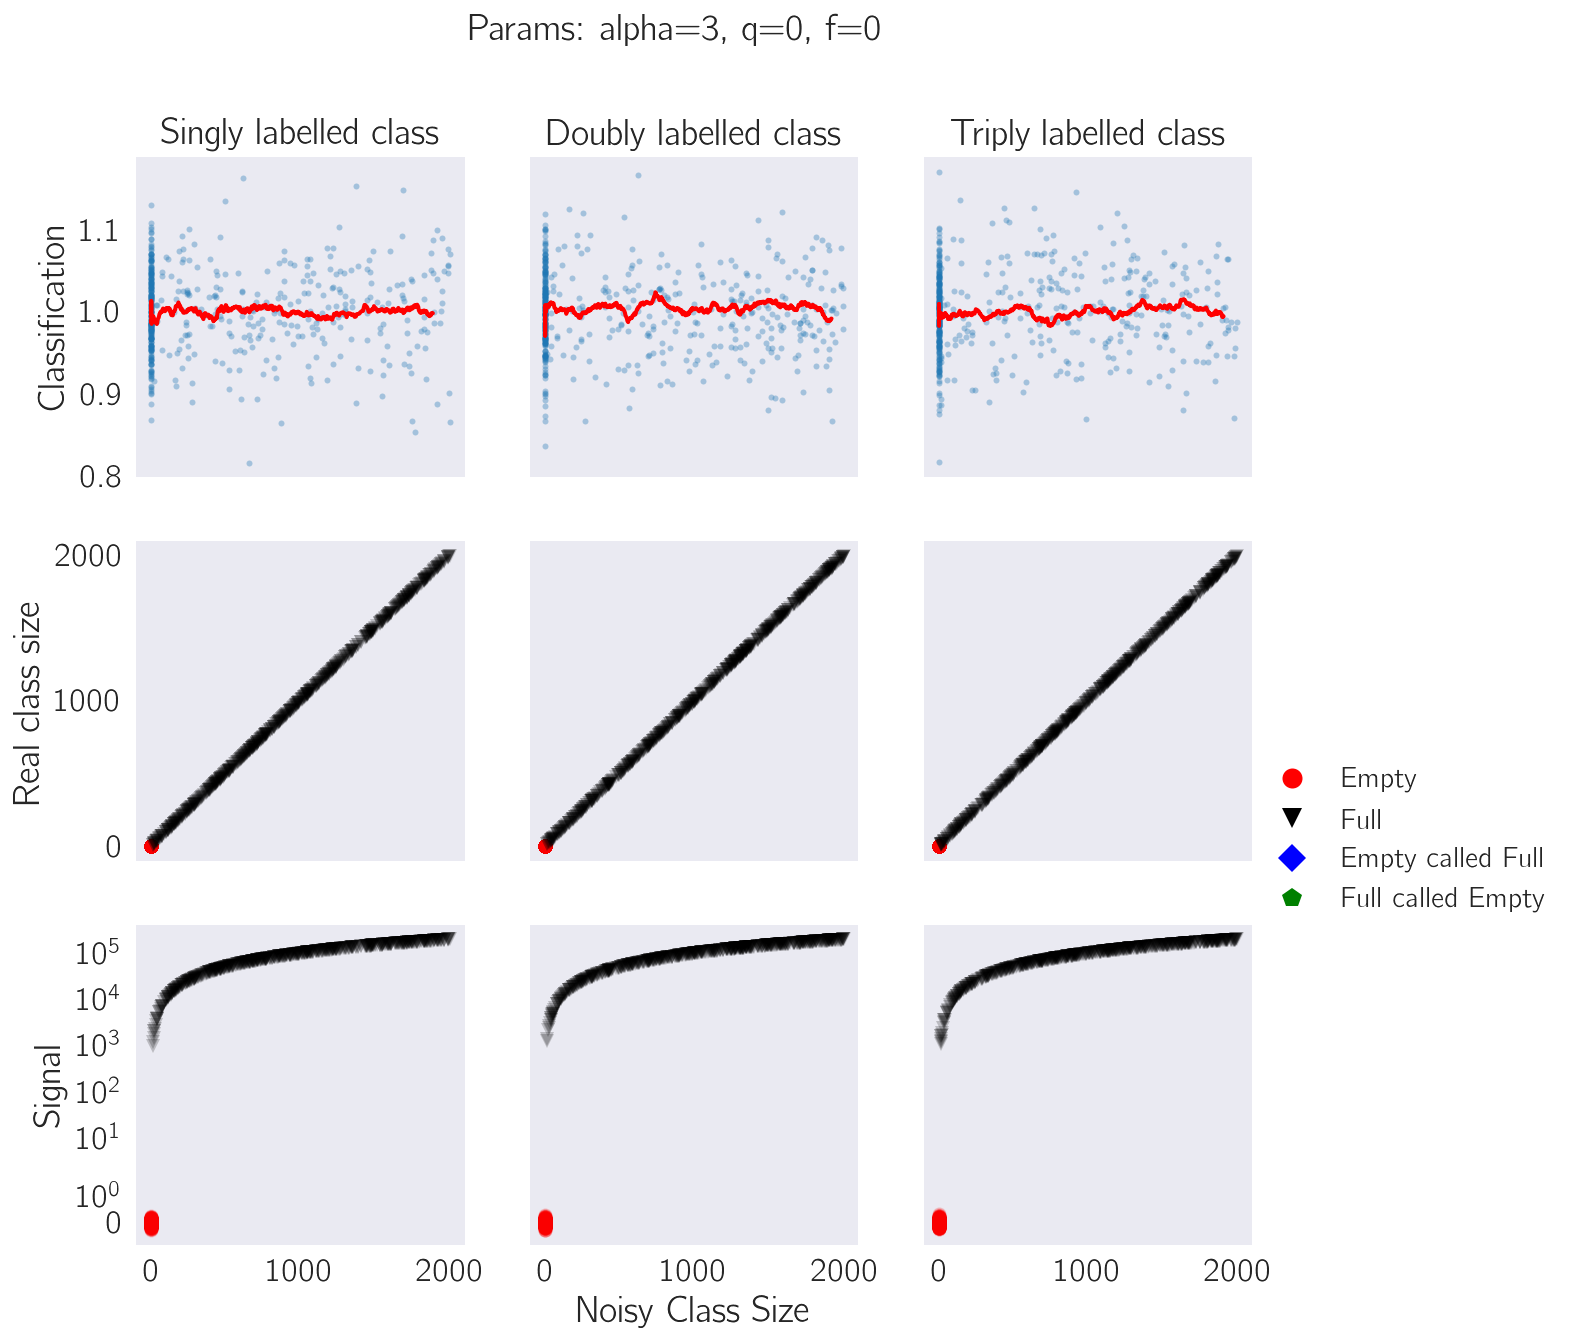

In [7]:
fig, ax = study(3, 0, 0)

## Running false hit analysis with a non-zero false positive rate

fraction of categories correctly classified:
category            M100                M110                M111                
Full                0.82                0.99                0.99                
Empty               0.95                0.78                0.8                 


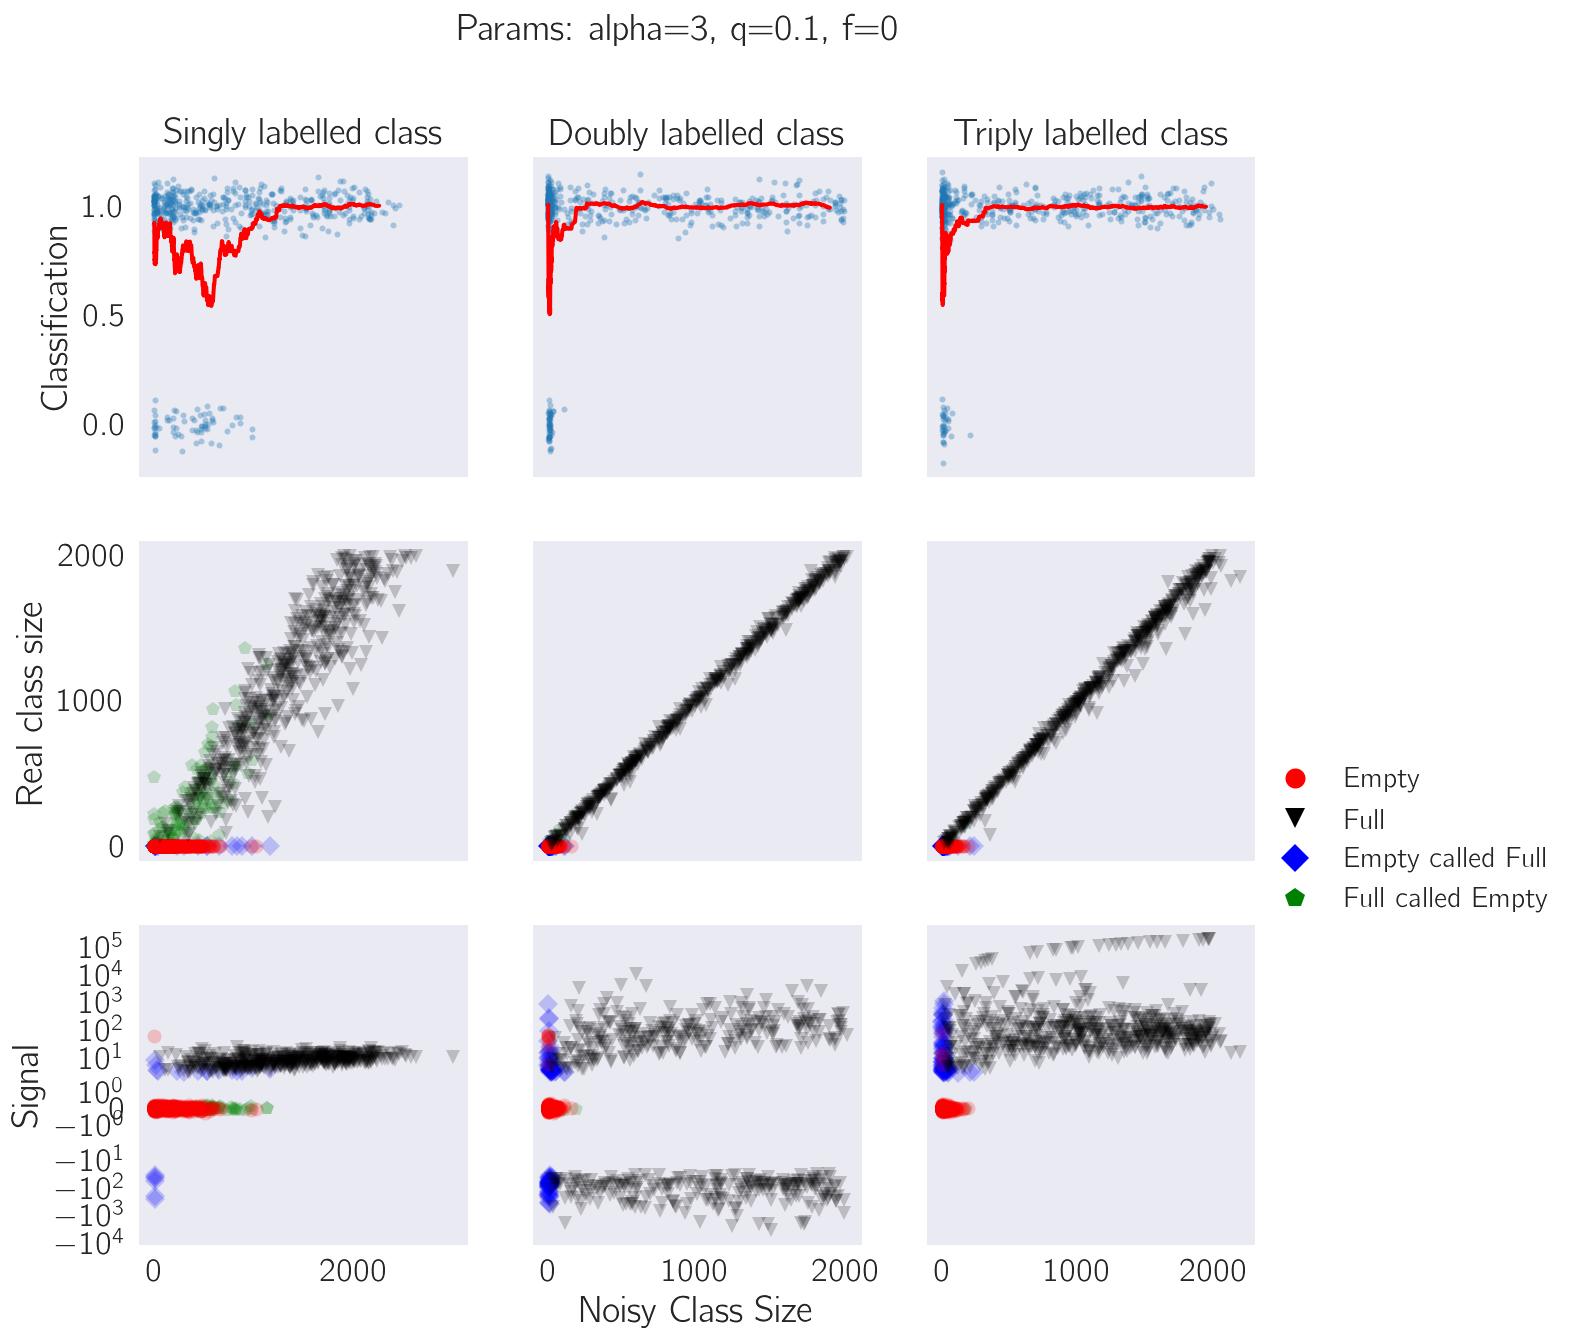

In [8]:
fig, ax = study(3, 0.1, 0)

Our algorithm can accurately identify when the innermost class is full 99% of the time! On the other hand, it can identify when this class is empty only 80% of the time. In general, the diagnostics look good.

Notice that for some classes the signal indicator can go negative. This is the result of using first order approximations to the noise. My workaround has been to accept any signals that are negative as indicators the class is real. 

## Simulating a false negative rate

fraction of categories correctly classified:
category            M100                M110                M111                
Full                0.93                0.95                0.98                
Empty               0.84                0.7                 0.56                


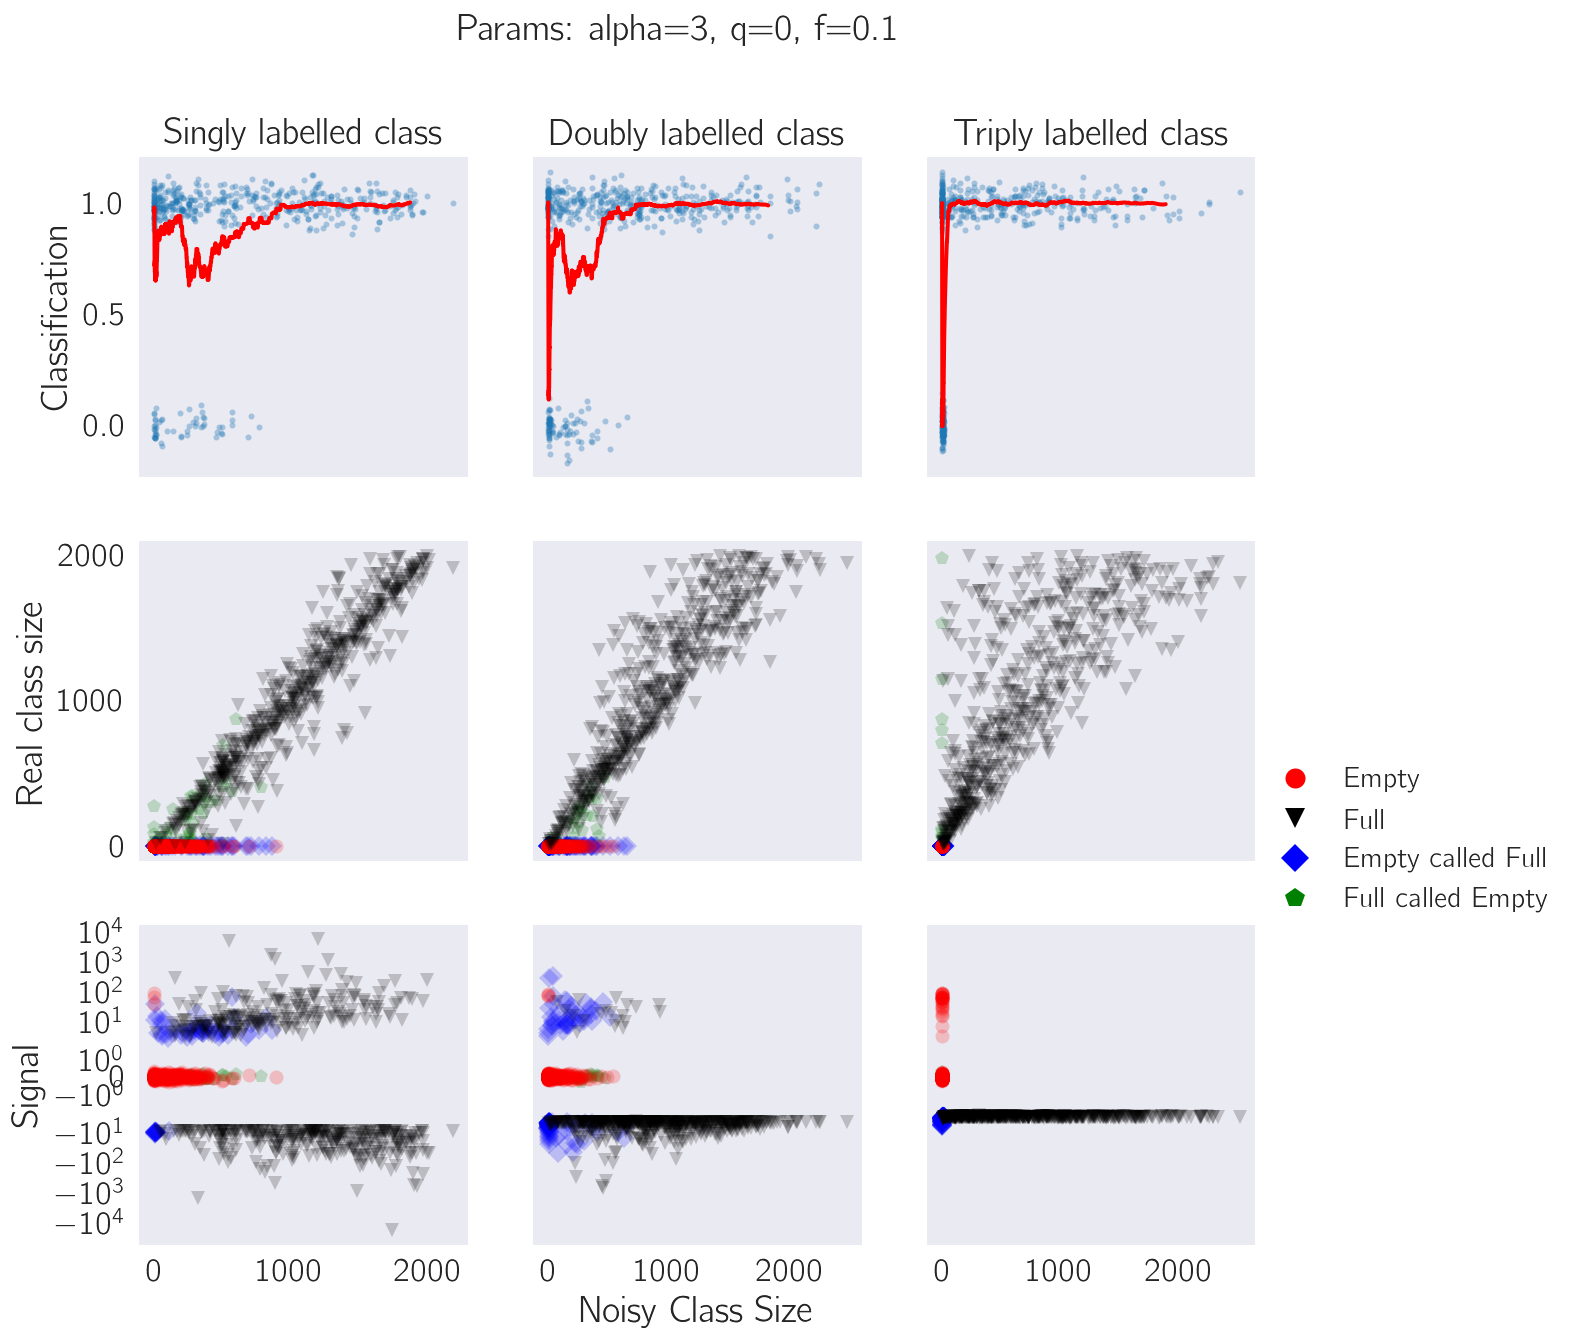

In [47]:
fig, ax = study(3, 0, 0.1)

We can see that false negative rates make it considerably harder to identify empty classes as empty than before. This makes sense. However, we can still tell when a class is full.

## Simulations with both false positive and negative rates

fraction of categories correctly classified:
category            M100                M110                M111                
Full                0.76                0.97                0.98                
Empty               0.97                0.76                0.77                


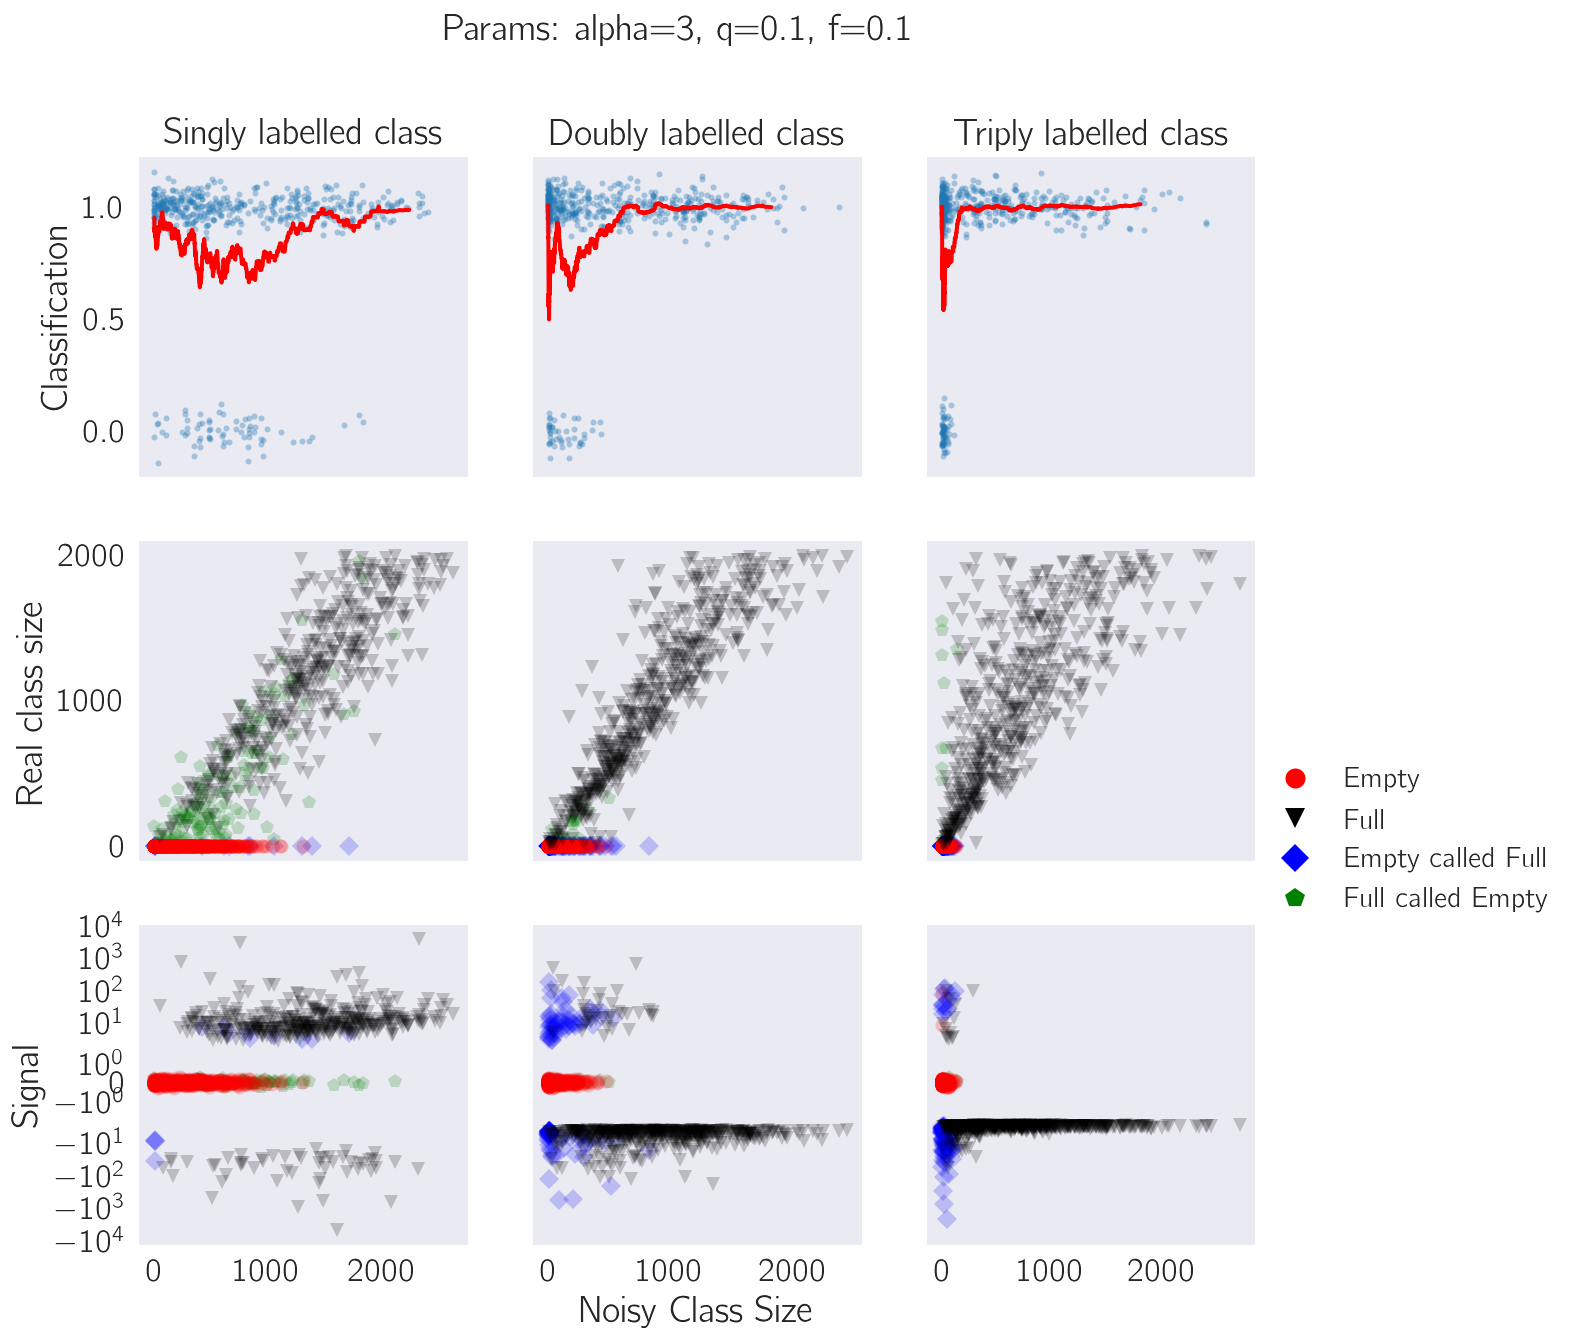

In [48]:
fig, ax = study(3, 0.1, 0.1)

We can see that, surprisingly, the case of mixed rates has better performance than the case where we only have false negative hits. The reason for this is likely the antagonism between these two kinds of errors. 

# Applying the algorithm to the *dpy-22* data

In [39]:
# parameters for the model:
N_T = 19416  # genes in genome
N_sy = 2036  # DE genes in sy homo
N_bx = 266  # DE genes in bx homo
N_het = 2128  # DE genes in het
M100, M010, M001 = 1213, 37, 1302  # sy-, bx-, and het-specific intersections
M110, M101, M011 = 38, 665, 41  # double intersections
M111 = 150  # triple
alpha = 3  # signal/noise threshold

# initialize the observed object:
M_obs = pheno.Model(N_sy, N_bx, N_het, N_T,
                    M100, M010, M001,
                    M110, M101, M011,
                    M111,
                    fn=0, fp=0)

# minimal model:
k_min = (0, 0, 0, 0, 0, 0, M111)

# iterate to reach a final model:
final = iterate(M_obs, N_sy, N_bx, N_het, N_T - M111,
                k_min, alpha=alpha, fp=0.1, fn=0.15)

# define a chi_square:
def chi2(M_obs, final):
    """Calculate sum_i (Obs_i - Exp_i)**2/Exp_i"""
    Obs = M_obs.M
    Exp = final.M + final.fps + final.fns
    chi_final = ((Obs - Exp)**2/Exp).sum()
    return chi_final

[1213    0 1302    0  665    0  150]


## Testing whether a re-classified model improves chi-square

In [45]:
# reclassified model:
M_reclassified = pheno.Model(N_sy, N_bx - M010, N_het, N_T + M010,
                             M100, 0, M001,
                             0, M101, 0,
                             M111 + M110 + M011,
                             fn=0.1, fp=0.15)

# test and refine the new model:
M_reclassified.signal_threshold(alpha)
M_reclassified.test_classes(M_obs.M)
chi_reclass = chi2(M_obs, M_reclassified)

# print results:
print('Chi2 for the non-reclassified model was {0:.2g}'.format(chi))
print('Chi2 for the reclassified model was {0:.2g}'.format(chi_reclass))
print('Improvement factor was {0:.2g}'.format(chi/chi_reclass))

print('\nBoth models were the same: {0}'.format((M_final.accepted ==
                                                 M_reclassified.accepted
                                                ).all()
                                               )
     )

print('\nAccepted reclassified model was:')
print(M_reclassified.accepted)

Chi2 for the non-reclassified model was 1.3e+02
Chi2 for the reclassified model was 72
Improvement factor was 1.9

Both models were the same: True

Accepted reclassified model was:
[1213    0 1302    0  665    0  150]


Clearly, re-classifying the model improves our chi-squared between expectation and observations. Moreover, both models give the same answer, and suggest strongly that the bx-specific class is false. Both models also support the case that the bx93 differential transcriptome should be entirely contained within the triple intersection.  